In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyradiomics tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 52.9 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp310-cp310-linux_x86_64.whl size=186232 sha256=bb3bbc04e27510b56a638dc0eca2fd911b627e5e2b661ebb85073957dd189ab6
  Stored in directory: /root/.cache/pip/wheels/91/c5/13/c5fd4c5ad3edf4062bb3855bd66fad25871c9c6dc0b3fda544
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=08b5b689412ea20f889d9fb68f85325014d2bf045f32b

In [3]:
import pandas as pd
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB
from radiomics import featureextractor
import nibabel as nib
import os
import glob
import numpy as np
from shutil import copyfile, copytree
import pickle

# you don't need this outside Google COLAB

#!pip install -U tensorboard-plugin-profile

#set up imports
#%tensorflow_version 2.x 
# previousl line only needed when working in google COLAB
import matplotlib
#matplotlib.use('Agg')
import glob
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D
from tensorflow.keras.layers import ZeroPadding2D,Add,ReLU,AveragePooling2D
from tensorflow.keras import metrics as mtt
from tensorflow.keras import optimizers
from tensorflow import keras

import tensorflow_addons as tfa # seg-net architecture
from keras.layers import Input, Activation, Reshape, BatchNormalization
from keras.models import Model
from keras.layers.convolutional import Convolution2D 

import math
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
copytree("drive/MyDrive/Medical Imaging Progetto","progetto")

'progetto'

# Train log plots

In [5]:
columns = ["epoch","loss","dice_accuracy","val_loss","val_dice_accuracy"]

In [6]:
log_unet = pd.read_csv("progetto/Train log2/unet_hist.csv")
log_segnet = pd.read_csv("progetto/Train log2/Segnet.csv")
log_resunet = pd.read_csv("progetto/Train log2/Resunet.csv")

In [7]:
log_unet.columns = columns
log_segnet.columns = columns
log_resunet.columns = columns

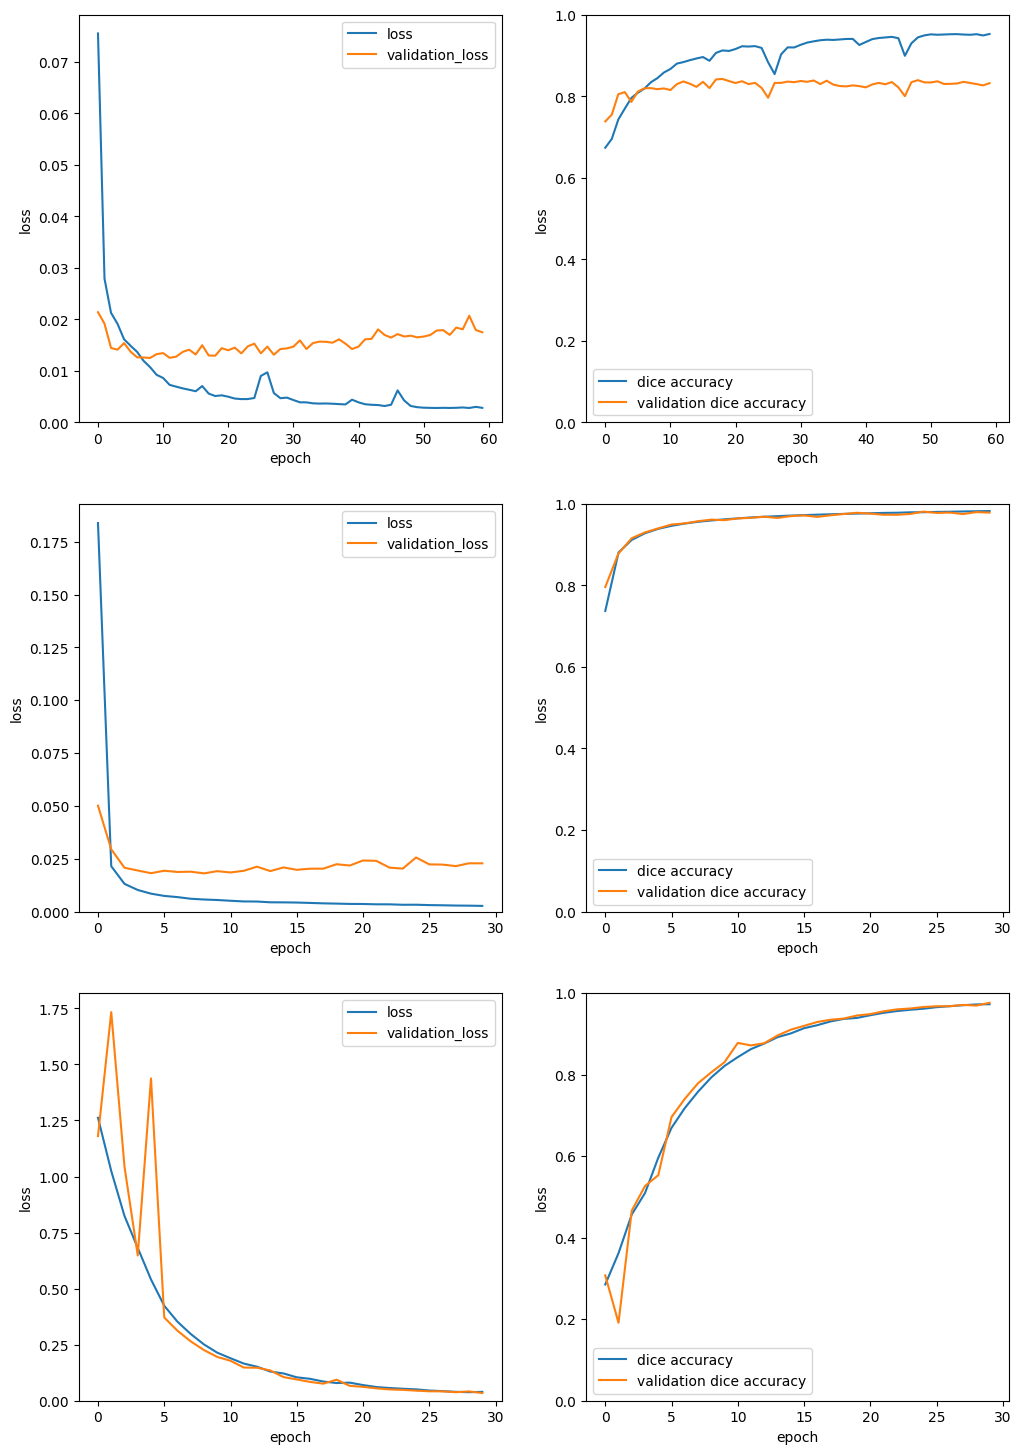

In [8]:
plt.figure(figsize=(12,18))
plt.subplot(321)
plt.plot(log_unet['loss'], label="loss")
plt.plot(log_unet['val_loss'], label="validation_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,)
plt.subplot(322)
plt.plot(log_unet['dice_accuracy'], label="dice accuracy")
plt.plot(log_unet['val_dice_accuracy'], label="validation dice accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,1)


plt.subplot(323)
plt.plot(log_resunet['loss'], label="loss")
plt.plot(log_resunet['val_loss'], label="validation_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,)
plt.subplot(324)
plt.plot(log_resunet['dice_accuracy'], label="dice accuracy")
plt.plot(log_resunet['val_dice_accuracy'], label="validation dice accuracy")
plt.legend(loc="lower left")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,1)


plt.subplot(325)
plt.plot(log_segnet['loss'], label="loss")
plt.plot(log_segnet['val_loss'], label="validation_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,)
plt.subplot(326)
plt.plot(log_segnet['dice_accuracy'], label="dice accuracy")
plt.plot(log_segnet['val_dice_accuracy'], label="validation dice accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(0,1)

plt.savefig("Training curves.png", dpi=300)

# Prepare test set

In [9]:
import gdown

!gdown "19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True"

import zipfile
with zipfile.ZipFile("brats.zip", 'r') as zip_ref:
    zip_ref.extractall("")

Downloading...
From: https://drive.google.com/uc?id=19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True
To: /content/brats.zip
100% 5.49G/5.49G [01:18<00:00, 69.7MB/s]


In [10]:
files = []

for root in os.listdir("content/GBM"):
  files.append(os.path.join("content/GBM",root))

for root in os.listdir("content/LGG"):
  files.append(os.path.join("content/LGG",root))

In [11]:
channels = ["t1","t1ce","t2","flair"]

nPat = 50
nChan = len(channels)

In [12]:
import random
random.seed(12345)
random.shuffle(files)

In [13]:
immV = np.zeros((10,120,120,77,nChan),dtype=np.float32)
segV = np.zeros((10,120,120,77,1),dtype=np.float32)

In [14]:
for id,filepath in enumerate(files[nPat+20:nPat+30]):
    for x, channel in enumerate(channels):
        head = nib.load(os.path.join(filepath,str(channel + ".nii.gz")))
        temp = head.get_fdata(dtype=np.float32)
        temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F')
        immV[id,:,:,:,x] = np.mean(np.mean(np.mean(temp,axis=-2),axis=-3),axis=0)
    head = nib.load(os.path.join(filepath, "truth.nii.gz"))
    temp = head.get_fdata(dtype=np.float32)
    temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F') 
    segV[id,:,:,:,0]= np.max(np.max(np.max(temp,axis=-2),axis=-3),axis=0)

In [15]:
rnge = np.zeros((immV.shape[0],nChan),dtype=np.float32)
for sub in range(immV.shape[0]):
  for chan in range(nChan):
    temp = np.squeeze(immV[sub,:,:,:,chan])
    soglia = np.percentile(temp,1)
    temp_filtered = temp[temp > soglia]
    if len(temp_filtered) > 0:
        rnge[sub, chan] = np.percentile(temp_filtered, 50)
    else:
        # Gestisci il caso in cui l'array filtrato sia vuoto o non abbia elementi validi
        # Ad esempio, puoi assegnare un valore predefinito a rnge[sub, chan]
        rnge[sub, chan] = 0.0  # O qualsiasi altro valore che abbia senso nel tuo contesto
rnge = rnge.reshape((immV.shape[0],1,1,1,nChan))   
immV = (immV-0.5*rnge)/rnge

(-0.5, 76.5, 119.5, -0.5)

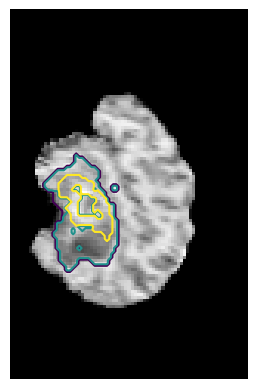

In [16]:
plt.figure()
plt.imshow(immV[2,35,:,:,0],vmin=-0.3,vmax=1.0,cmap='Greys_r')
plt.contour(segV[2,35,:,:,0],[0.5,1.5,2.5])
plt.axis('off')

In [17]:
len(immV)

10

In [18]:
nTest = len(immV)

X_test = np.zeros((nTest,128,128,77,nChan),dtype=np.float32)
y_test = np.zeros((nTest,128,128,77,1),dtype=np.float32)

minimo = immV.min()

X_test = np.clip(X_test, minimo,minimo)

X_test[:,:120,:120,:,:] = immV[:nTest]
del immV
y_test[:,:120,:120,:,:] = segV[:nTest]
del segV

y_test[y_test>3.5]=3
y_test = tf.keras.utils.to_categorical(y_test)

In [19]:
X_test = X_test.transpose((0,3,1,2,4))
X_test = X_test.reshape((-1,128,128,4))
y_test = y_test.transpose((0,3,1,2,4))
y_test = y_test.reshape((-1,128,128,4))

In [20]:
print(X_test.shape)
print(y_test.shape)

(770, 128, 128, 4)
(770, 128, 128, 4)


# Load models

## Unet

In [21]:
inputL = Input([X_test.shape[1],X_test.shape[2],nChan])
## Encoder section
# 120x120 resolution layers
c1 = Conv2D(16,3,activation='relu',padding='same') (inputL)
c2 = Conv2D(16,3,activation='relu',padding='same') (c1)

c3 = MaxPooling2D() (c2) # 60x60
c4 = Conv2D(32,3,activation='relu',padding='same') (c3)
c5 = Conv2D(32,3,activation='relu',padding='same') (c4)

c6 = MaxPooling2D() (c5) #30x30
c7 = Conv2D(64,3,activation='relu',padding='same') (c6)
c8 = Conv2D(64,3,activation='relu',padding='same') (c7)

c9 = MaxPooling2D() (c8) #15x15
## Bridge
# "low resolution" high abstraction layer
c10 = Conv2D(128,3,activation='relu',padding='same') (c9)
c11 = Conv2D(128,3,activation='relu',padding='same') (c10)
c12 = Conv2D(128,3,activation='relu',padding='same') (c11)
c13 = UpSampling2D() (c12) #30x30

## "Decoder" network
# upsample the output and concatenate it to the encoder layer at the same resolution
c14 = concatenate([c13,c8])
c15 = Conv2D(64,3,activation='relu',padding='same') (c14)
c16 = Conv2D(64,3,activation='relu',padding='same') (c15)

c17 = UpSampling2D() (c16) #60x60
c18 = concatenate([c17,c5])
c19 = Conv2D(32,3,activation='relu',padding='same') (c18)
c20 = Conv2D(32,3,activation='relu',padding='same') (c19)

c21 = UpSampling2D() (c20) #120x120
c22 = concatenate([c21,c2])
c23 = Conv2D(16,3,activation='relu',padding='same') (c22)
c24 = Conv2D(16,3,activation='relu',padding='same') (c23)

# Output layer. We have 4 classes as output (0: background + 3 types of tumor)
# Therefore we use a softmax activation and 4 channels of output
outL = Conv2D(4,3,activation='softmax',padding='same')(c24)
unet = Model(inputs=inputL,outputs=outL)

In [22]:
unet.load_weights("progetto/Modelli2/unet.h5")

## ResUNet

In [23]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.ReLU()(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [24]:
f = [16, 32, 64, 128, 256]
inputs = keras.layers.Input((128, 128, 4))

## Encoder
e0 = inputs
e1 = stem(e0, f[0])
e2 = residual_block(e1, f[1], strides=2)
e3 = residual_block(e2, f[2], strides=2)
e4 = residual_block(e3, f[3], strides=2)
e5 = residual_block(e4, f[4], strides=2)

## Bridge
b0 = conv_block(e5, f[4], strides=1)
b1 = conv_block(b0, f[4], strides=1)

## Decoder
u1 = upsample_concat_block(b1, e4)
d1 = residual_block(u1, f[4])

u2 = upsample_concat_block(d1, e3)
d2 = residual_block(u2, f[3])

u3 = upsample_concat_block(d2, e2)
d3 = residual_block(u3, f[2])

u4 = upsample_concat_block(d3, e1)
d4 = residual_block(u4, f[1])

outputs = keras.layers.Conv2D(4, (1, 1), padding="same", activation="sigmoid")(d4)
resunet = keras.models.Model(inputs, outputs)

In [25]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.compat.v1.layers.flatten(y_true)
    y_pred_f = tf.compat.v1.layers.flatten(y_pred)
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [26]:
resunet.load_weights("progetto/Modelli2/ResUNet.h5")

## Segnet

In [27]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

In [28]:
def Segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(input_shape, batch_size = 1)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0], input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)

    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [29]:
segnet = Segnet([128, 128, 4], 4)

Build enceder done..
Build decoder done..


In [31]:
segnet.load_weights("progetto/Modelli2/Copia di EncDecSegNet.h5")

# Compute dice scores

In [32]:
def diceFromMap(map1,map2):
    unionLab = np.sum(map1) +np.sum(map2)
    interLab = np.sum(map1 & map2, dtype=np.float32)
    return (2*interLab+.1)/(unionLab+.1)
def computeDices (yPred,yTrue):
    yPred = np.asarray(yPred)
    yTrue = np.asarray(yTrue)
    if np.sum(yTrue[:,:,:,1:])<1:
        return(np.nan,np.nan,np.nan)
    diceWhole = diceFromMap(np.sum(yPred[:,:,:,1:],axis=-1)>np.sum(yPred[:,:,:,:1],axis=-1),
                            np.sum(yTrue[:,:,:,1:],axis=-1)>np.sum(yTrue[:,:,:,:1],axis=-1))
    diceCore = diceFromMap(np.sum(yPred[:,:,:,2:],axis=-1)>np.sum(yPred[:,:,:,:2],axis=-1),
                           np.sum(yTrue[:,:,:,2:],axis=-1)>np.sum(yTrue[:,:,:,:2],axis=-1))
    diceEnh = diceFromMap(np.sum(yPred[:,:,:,3:],axis=-1)>np.sum(yPred[:,:,:,:3],axis=-1),
                          np.sum(yTrue[:,:,:,3:],axis=-1)>np.sum(yTrue[:,:,:,:3],axis=-1))
    return (diceWhole,diceCore,diceEnh)

In [33]:
diceV_unet = np.zeros((10,3))
for idx in range(10):
    yPred = unet(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV_unet[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

In [34]:
diceV_resunet = np.zeros((10,3))
for idx in range(10):
    yPred = resunet(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV_resunet[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

In [35]:
diceV_segnet = np.zeros((10,3))
for idx in range(10):
    yPred = segnet(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV_segnet[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

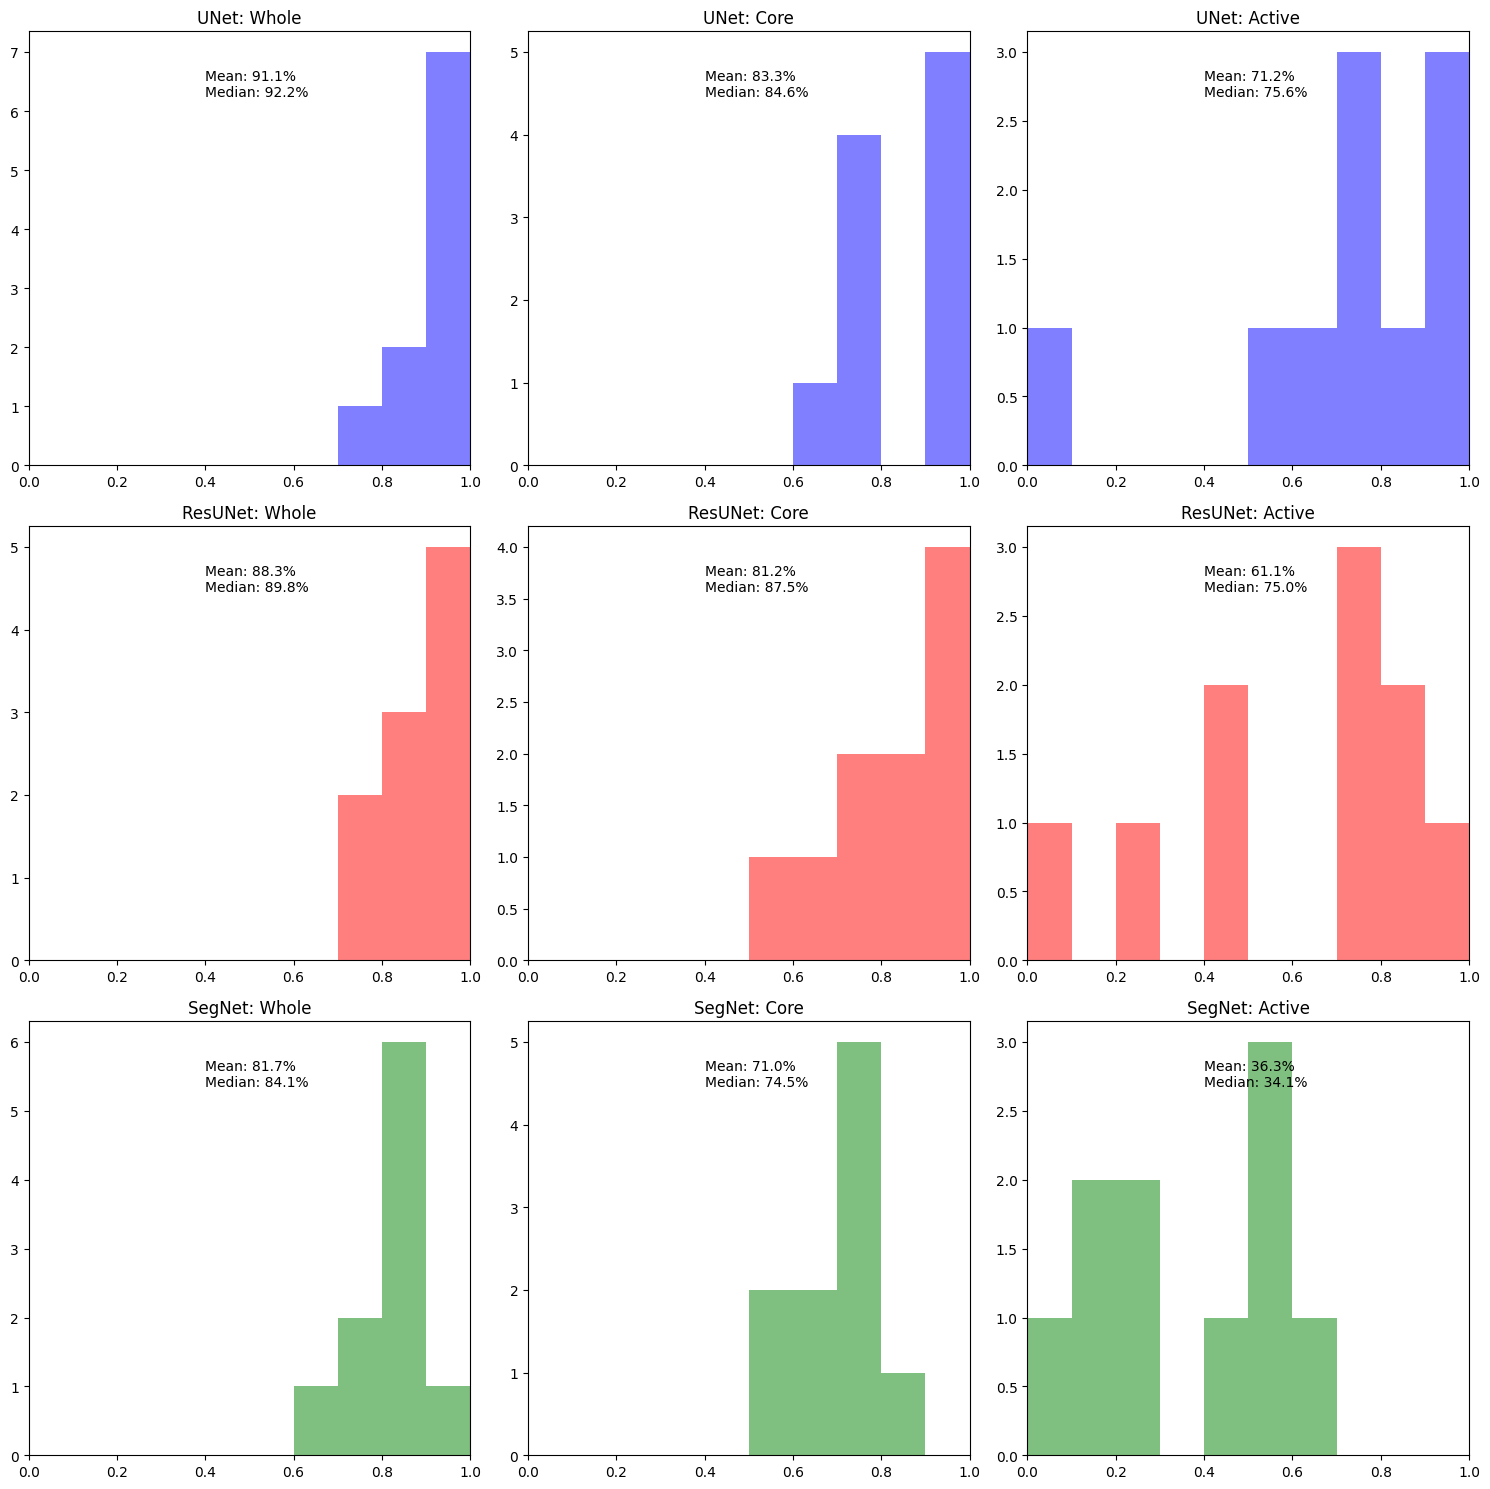

In [36]:
titleList = ['Whole','Core','Active']

matrices = [diceV_unet, diceV_resunet,diceV_segnet]
models = ["UNet", "ResUNet", "SegNet"]
colors = ["blue","red","green"]
# Create subplots with three rows and one column
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the matrices
for idx, matrix in enumerate(matrices):
    # Iterate over the columns of each matrix
    for i in range(3):
        # Select the appropriate subplot
        ax = axes[idx,i]

        # Plot the histogram
        ax.hist(matrix[:, i], bins=10, range=(0, 1), alpha=0.5, color=colors[idx])

        # Set x-axis limits
        ax.set_xlim(0, 1)

        # Set plot title
        ax.set_title(f'{models[idx]}: {titleList[i]}')

        # Calculate mean and median
        mean = np.mean(matrix[:, i] * 100)
        median = np.median(matrix[:, i] * 100)

        # Embed string with mean and median values in the plot
        text_str = f"Mean: {mean:.1f}%\nMedian: {median:.1f}%"
        ax.text(0.40, 0.85, text_str, transform=ax.transAxes, fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

plt.savefig("dicescoresgrid.png", dpi=300)
# Show the plots
plt.show()


# Gif Animation for Brain Tumor segmentation

## Unet

In [37]:
import matplotlib.animation as animation
from PIL import Image

# Assuming 'patIdx', 'slStart', 'slStop', 'slStep', 'X_test', 'yTrue', 'yPred' are defined

# Initialize a list to store the frames
frames = []

patIdx = 2
slStart = 3
slStop = 70
slStep = 5


yPred = np.array(unet.predict(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)

# Iterate over the desired slice range
for slIdx in range(slStart, slStop, slStep):
    # Create a new figure
    fig = plt.figure(figsize=(9, 3))
    plt.title("UNet")
    # Plot the first subplot
    ax1 = plt.subplot(131)
    ax1.imshow(X_test[patIdx*77+slIdx, :, :, 1], vmin=-0.3, vmax=1.0, cmap='gray')
    ax1.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5])
    ax1.axis('off')

    # Plot the second subplot
    ax2 = plt.subplot(132)
    ax2.imshow(X_test[patIdx*77+slIdx, :, :, 2], vmin=-0.3, vmax=1.0, cmap='gray')
    ax2.axis('off')

    # Plot the third subplot
    ax3 = plt.subplot(133)
    ax3.imshow(yPred[slIdx, :, :], vmin=0, vmax=3)
    ax3.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5], cmap='jet')
    ax3.axis('off')

    # Save the figure as an image
    plt.tight_layout()
    plt.savefig(f'frame_{slIdx}.png')

    # Append the image to the frames list
    frames.append(Image.open(f'frame_{slIdx}.png'))

    # Close the figure to avoid memory leaks
    plt.close()

# Save the frames as a GIF animation
frames[0].save('unet.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)


3/3 [==============================] - 2s 262ms/step


<ipython-input-37-4d95731c52ef>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(131)


## ResUNet

In [38]:
import matplotlib.animation as animation
from PIL import Image

# Assuming 'patIdx', 'slStart', 'slStop', 'slStep', 'X_test', 'yTrue', 'yPred' are defined

# Initialize a list to store the frames
frames = []

patIdx = 2
slStart = 3
slStop = 70
slStep = 5


yPred = np.array(resunet.predict(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)

# Iterate over the desired slice range
for slIdx in range(slStart, slStop, slStep):
    # Create a new figure
    fig = plt.figure(figsize=(9, 3))
    plt.title("UNet")
    # Plot the first subplot
    ax1 = plt.subplot(131)
    ax1.imshow(X_test[patIdx*77+slIdx, :, :, 1], vmin=-0.3, vmax=1.0, cmap='gray')
    ax1.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5])
    ax1.axis('off')

    # Plot the second subplot
    ax2 = plt.subplot(132)
    ax2.imshow(X_test[patIdx*77+slIdx, :, :, 2], vmin=-0.3, vmax=1.0, cmap='gray')
    ax2.axis('off')

    # Plot the third subplot
    ax3 = plt.subplot(133)
    ax3.imshow(yPred[slIdx, :, :], vmin=0, vmax=3)
    ax3.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5], cmap='jet')
    ax3.axis('off')

    # Save the figure as an image
    plt.tight_layout()
    plt.savefig(f'frame_{slIdx}.png')

    # Append the image to the frames list
    frames.append(Image.open(f'frame_{slIdx}.png'))

    # Close the figure to avoid memory leaks
    plt.close()

# Save the frames as a GIF animation
frames[0].save('resunet.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)


3/3 [==============================] - 4s 667ms/step


<ipython-input-38-e886ff9b0308>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(131)


## SegNet

In [39]:
import matplotlib.animation as animation
from PIL import Image

# Assuming 'patIdx', 'slStart', 'slStop', 'slStep', 'X_test', 'yTrue', 'yPred' are defined

# Initialize a list to store the frames
frames = []

patIdx = 2
slStart = 3
slStop = 70
slStep = 5


yPred = np.array(segnet.predict(X_test[(patIdx*77):((patIdx+1)*77),:,:,:]))
yPred = np.argmax(yPred,axis=-1)
yTrue = y_test[(patIdx*77):((patIdx+1)*77),:,:,:]
yTrue = np.argmax(yTrue,axis=-1)

# Iterate over the desired slice range
for slIdx in range(slStart, slStop, slStep):
    # Create a new figure
    fig = plt.figure(figsize=(9, 3))
    plt.title("UNet")
    # Plot the first subplot
    ax1 = plt.subplot(131)
    ax1.imshow(X_test[patIdx*77+slIdx, :, :, 1], vmin=-0.3, vmax=1.0, cmap='gray')
    ax1.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5])
    ax1.axis('off')

    # Plot the second subplot
    ax2 = plt.subplot(132)
    ax2.imshow(X_test[patIdx*77+slIdx, :, :, 2], vmin=-0.3, vmax=1.0, cmap='gray')
    ax2.axis('off')

    # Plot the third subplot
    ax3 = plt.subplot(133)
    ax3.imshow(yPred[slIdx, :, :], vmin=0, vmax=3)
    ax3.contour(yTrue[slIdx, :, :], [0.5, 1.5, 2.5], cmap='jet')
    ax3.axis('off')

    # Save the figure as an image
    plt.tight_layout()
    plt.savefig(f'frame_{slIdx}.png')

    # Append the image to the frames list
    frames.append(Image.open(f'frame_{slIdx}.png'))

    # Close the figure to avoid memory leaks
    plt.close()

# Save the frames as a GIF animation
frames[0].save('segnet.gif', format='GIF', append_images=frames[1:], save_all=True, duration=1000, loop=0)


3/3 [==============================] - 6s 1s/step


<ipython-input-39-d10e526b8192>:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(131)
